# Occupation mobility network - Top 5 Races
Nodes represent occupations <br>
Edges represent transitions between occupations

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib
import json
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer
import seaborn as sns
from plottable import Table

In [2]:
#pd.set_option('display.max_rows', None)

Load the data prepared in basic_exploration

In [3]:
data_path = r'../data/cps_clean_original_races.csv'
race_occ_path = r'../data/race_codes.txt'
occ2010_data_path = r'../data/occ2010_codes.txt'

In [4]:
race_codes_df = pd.read_csv(race_occ_path, sep=';')


In [5]:
occ2010_df = pd.read_csv(occ2010_data_path, sep='                ', header=None)
occ2010_df.columns = ['OCC2010', 'occ_title']

C:\Users\jputz\AppData\Local\Temp\ipykernel_8512\1474149184.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  occ2010_df = pd.read_csv(occ2010_data_path, sep='                ', header=None)


In [6]:
occ2010_df

,OCC2010,occ_title
0,10,Chief executives and legislators/public admini...
1,20,General and Operations Managers
2,30,"Managers in Marketing, Advertising, and Public..."
3,100,Administrative Services Managers
4,110,Computer and Information Systems Managers
...,...,...
453,9800,Military Officer Special and Tactical Operatio...
454,9810,First-Line Enlisted Military Supervisors
455,9820,Military Enlisted Tactical Operations and Air/...
456,9830,"Military, Rank Not Specified"


In [7]:
occ2010_df.set_index('OCC2010').to_dict()

{'occ_title': {10: 'Chief executives and legislators/public administration',
  20: 'General and Operations Managers',
  30: 'Managers in Marketing, Advertising, and Public Relations',
  100: 'Administrative Services Managers',
  110: 'Computer and Information Systems Managers',
  120: 'Financial Managers',
  130: 'Human Resources Managers',
  140: 'Industrial Production Managers',
  150: 'Purchasing Managers',
  160: 'Transportation, Storage, and Distribution Managers',
  205: 'Farmers, Ranchers, and Other Agricultural Managers',
  220: 'Constructions Managers',
  230: 'Education Administrators',
  300: 'Architectural and Engineering Managers',
  310: 'Food Service and Lodging Managers',
  320: 'Funeral Directors',
  330: 'Gaming Managers',
  350: 'Medical and Health Services Managers',
  360: 'Natural Science Managers',
  410: 'Property, Real Estate, and Community Association Managers',
  420: 'Social and Community Service Managers',
  430: 'Managers, nec (including Postmasters)',
  5

---

## 2023 for top 5 races

important note: If an occupation (e.g. 8100 for black) does not exist in OCC but in OCCLY in 2023 one would assume that in the previous year (e.g. 2022) there would be an entry where OCC is this occupation (e.g. 8100). But this is NOT true. Probably because that exact person reporting this was not interviewed in the previous year.

In [8]:
def create_graph(race: int, year: int, save: bool = True) -> nx.Graph:
    last_year = year-1
    data_df = pd.read_csv(data_path, sep=';')

    data_r = data_df[data_df['RACE'] == race]
    data_23 = data_r[data_r['YEAR'] == year]

    data_23 = data_23[['OCC2010', 'OCC10LY', 'Category', 'ASECWT', 'INCWAGE']]
    data_23['OCC2010'] = data_23['OCC2010'].astype('int64')
    data_23['OCC10LY'] = data_23['OCC10LY'].astype('int64')

    # calculate avg income per occupation in 2023
    average_wages_df = data_23.groupby('OCC2010')['INCWAGE'].mean().reset_index()
    average_wages_df.columns = ['OCC2010', 'Average_INCWAGE']
    
    scaler = MinMaxScaler()
    average_wages_df['Average_INCWAGE_scaled'] = scaler.fit_transform(average_wages_df['Average_INCWAGE'].values.reshape(-1, 1))

    data_23 = data_23.groupby(['OCC2010', 'OCC10LY', 'Category'])['ASECWT'].sum().reset_index()
    data_23 = data_23.merge(average_wages_df, on='OCC2010')

    # calculate avg income per occupation in 2022 (for OCCLY that are not transitioned to)
    average_wages_LY = data_r[data_r['YEAR'] == last_year].groupby('OCC2010')['INCWAGE'].mean().reset_index()
    average_wages_LY.columns = ['OCC2010', 'Average_INCWAGE']

    average_wages_df.set_index('OCC2010', inplace=True)
    average_wages_LY.set_index('OCC2010', inplace=True) 
    average_wages_df = average_wages_df.combine_first(average_wages_LY)
    average_wages_df.reset_index(inplace=True)

    # Get unique categories
    unique_categories = data_23['Category'].unique()

    # Create a dictionary to map categories to codes
    category_to_code = {category: code for code, category in enumerate(unique_categories)}

    # Add a new column with category codes
    data_23['category_code'] = data_23['Category'].map(category_to_code)

    G = nx.from_pandas_edgelist(data_23, source='OCC10LY', target='OCC2010', edge_attr=['ASECWT'], create_using=nx.DiGraph())

    # make sure every node gets assigned correct category code
    occ10_cat = data_23[['OCC2010', 'category_code']].drop_duplicates()
    occly10_cat = data_23[['OCC10LY', 'category_code']].drop_duplicates()

    occ10_cat.columns = ['OCC', 'category_code']
    occly10_cat.columns = ['OCC', 'category_code']

    merged_df = occ10_cat.merge(occly10_cat, on=['OCC', 'category_code'], how='outer')
    merged_df = merged_df.drop_duplicates(subset=['OCC'])
    merged_df = merged_df.merge(average_wages_df, left_on='OCC', right_on='OCC2010',  how='left')
    merged_df.drop('OCC2010', axis=1,  inplace=True)

    merged_df['Average_INCWAGE'] = merged_df['Average_INCWAGE'].fillna(0)
    node_attr = merged_df.set_index('OCC').to_dict('index')
    print(node_attr)

    # set occupation category and income as node attributes
    nx.set_node_attributes(G, node_attr)

    # remove selfloops
    G.remove_edges_from(nx.selfloop_edges(G))

    if save:
        mapping = occ2010_df.set_index('OCC2010').to_dict()
        H = nx.relabel_nodes(G, mapping.get('occ_title'))
        nx.write_gexf(H,f"./networks/network_{race}_{year}.gexf")

    return G

In [9]:
def plot_graph(G: nx.Graph, race: int):
    ## Compute a layout
    pos = nx.kamada_kawai_layout(G,
                                #weight="ASECWT",
                                scale=2)

    ## Fix a node ordering
    nodelist = G.nodes
    ## Convert classes labels to numbers for plotting
    colors = [G.nodes[ni]["category_code"] for ni in nodelist]
    size = [G.nodes[node]['Average_INCWAGE_scaled']*500 for node in list(G.nodes)]

    plt.figure(figsize=(16, 13))
    nx.draw_networkx(G,
                    pos=pos,
                    #node_size=size,
                    font_size=7,
                    width=0.1, ## Edge width
                    #nodelist=nodelist, 
                    node_color=colors,
                    cmap="rainbow",
                    with_labels=True,
                    #labels={ni:G.nodes[ni]["category"] for ni in nodelist}, ## Label each node (student) with the class she attends
                    font_color="k"
                    )
    
    category_codes = set(colors)
    normalizer = matplotlib.colors.Normalize(0, len(category_codes))
    legend_labels = {code: f'Category {code}' for code in category_codes}
    handles = [plt.Line2D([], [], marker='o', linestyle='', color=plt.cm.rainbow(normalizer(i)), markersize=10, label=label) for i, label in enumerate(legend_labels.values())]
    plt.legend(handles=handles, title='Category Code', loc='upper right', bbox_to_anchor=(1.1, 0.9))

    race_title = race_codes_df[race_codes_df['RACE'] == race]['race_title'].values[0]
    plt.title(f'{race_title} 2023')
    plt.axis("off")
    plt.show()

In [10]:
def calc_centrality_measures(G: nx.Graph, max_iter: int = None) -> pd.DataFrame:
    # degree centrality
    centrality = pd.DataFrame(nx.degree_centrality(G).items(), 
                                          columns=['OCC2010', 'degree'])
    centrality_df = occ2010_df.merge(centrality, how='right', on='OCC2010')

    # weighted degree centrality
    # source: https://www.kaggle.com/code/rahulgoel1106/network-centrality-using-networkx
    degree = G.degree(weight='ASECWT')
    max_degree = max(dict(degree).values())
    degree_centrality_w = [(k, deg/max_degree) for k, deg in dict(degree).items()]
    weighed_degree_centrality = pd.DataFrame.from_dict(degree_centrality_w)
    weighed_degree_centrality.columns=['OCC2010', 'weighted_degree']

    centrality_df = centrality_df.merge(weighed_degree_centrality, on='OCC2010')

    # weighted in degree centrality
    in_degree = G.in_degree(weight = 'ASECWT')
    max_in_degree = max(dict(in_degree).values())
    in_degree_centrality_w = [(k, deg/max_in_degree) for k, deg in dict(in_degree).items()]
    weighed_in_degree_centrality = pd.DataFrame.from_dict(in_degree_centrality_w)
    weighed_in_degree_centrality.columns = ['OCC2010', 'weighed_in_degree']

    centrality_df = centrality_df.merge(weighed_in_degree_centrality, on='OCC2010')

    # weighted out degree centrality
    out_degree = G.out_degree(weight = 'ASECWT')
    max_out_degree = max(dict(out_degree).values())
    out_degree_centrality_w = [(k, deg/max_out_degree) for k, deg in dict(out_degree).items()]
    weighed_out_degree_centrality = pd.DataFrame.from_dict(out_degree_centrality_w)
    weighed_out_degree_centrality.columns = ['OCC2010', 'weighed_out_degree']

    centrality_df = centrality_df.merge(weighed_out_degree_centrality, on='OCC2010')

    # betweenness centrality
    betweenness_centrality = pd.DataFrame(nx.betweenness_centrality(G).items(), 
                                          columns=['OCC2010', 'betweenness'])
    centrality_df = centrality_df.merge(betweenness_centrality, on='OCC2010')

    # closeness centrality
    closeness_centrality = pd.DataFrame(nx.closeness_centrality(G).items(), 
                                          columns=['OCC2010', 'closeness'])
    centrality_df = centrality_df.merge(closeness_centrality, on='OCC2010')

    # eigen-centrality
    if max_iter:
        eigen_centrality = pd.DataFrame(nx.eigenvector_centrality(G, max_iter=max_iter).items(), 
                                          columns=['OCC2010', 'eigenvector'])
    else:
        eigen_centrality = pd.DataFrame(nx.eigenvector_centrality(G).items(), 
                                          columns=['OCC2010', 'eigenvector'])
    centrality_df = centrality_df.merge(eigen_centrality, on='OCC2010')

    # PageRank
    pagerank = pd.DataFrame(nx.pagerank(G, weight='ASECWT').items(), 
                                          columns=['OCC2010', 'pagerank'])
    centrality_df = centrality_df.merge(pagerank, on='OCC2010')


    return centrality_df

In [11]:
def top_centrality(centralities: pd.DataFrame, amount: int, centrality: str):
    top = centralities.nlargest(amount, centrality)
    return top['occ_title'].values

In [12]:
def get_top_occ_centralities(centralities: pd.DataFrame, amount: int = 5) -> pd.DataFrame:
    top_centralities = pd.DataFrame(columns=['degree', 'weighted_degree', 'betweenness', 'closeness', 'eigenvector', 'pagerank'])
    
    top_centralities['degree'] = top_centrality(centralities, amount, 'degree')
    top_centralities['weighted_degree'] = top_centrality(centralities, amount, 'weighted_degree')
    top_centralities['betweenness'] = top_centrality(centralities, amount, 'betweenness')
    top_centralities['closeness'] = top_centrality(centralities, amount, 'closeness')
    top_centralities['eigenvector'] = top_centrality(centralities, amount, 'eigenvector')
    top_centralities['pagerank'] = top_centrality(centralities, amount, 'pagerank')

    return top_centralities

In [13]:
def combine_centrality_income(race: int, centrality_df: pd.DataFrame, year: int = 2023) -> pd.DataFrame:
    data_df = pd.read_csv(data_path, sep=';')

    data = data_df[data_df['YEAR'] == year]
    data = data[data['RACE'] == race]

    data = data[['OCC2010', 'INCWAGE']]

    # calculate avg income per occupation
    data = data.groupby(['OCC2010'])['INCWAGE'].mean().reset_index()
    data.columns = ['OCC2010', 'Average_INCWAGE']

    # merge with centrality measures
    centrality_wage = data.merge(centrality_df, on='OCC2010')

    return centrality_wage

#### White


In [14]:
data_df = pd.read_csv(data_path, sep=';')

data_23 = data_df[data_df['YEAR'] == 2023]
data_23 = data_23[data_23['RACE'] == 100]


data_23 = data_23[['OCC2010', 'OCC10LY', 'Category', 'ASECWT', 'INCWAGE']]

# calculate avg income per occupation in 2023
average_wages_df = data_23.groupby('OCC2010')['INCWAGE'].mean().reset_index()
average_wages_df.columns = ['OCC2010', 'Average_INCWAGE']
scaler = MinMaxScaler()
average_wages_df['Average_INCWAGE_scaled'] = scaler.fit_transform(average_wages_df['Average_INCWAGE'].values.reshape(-1, 1))
data_23 = data_23.groupby(['OCC2010', 'OCC10LY', 'Category'])['ASECWT'].sum().reset_index()
data_23 = data_23.merge(average_wages_df, on='OCC2010')

{10: {'category_code': 0, 'Average_INCWAGE': 183716.83980582524, 'Average_INCWAGE_scaled': 0.5544773837197945}, 20: {'category_code': 0, 'Average_INCWAGE': 122494.55602536998, 'Average_INCWAGE_scaled': 0.3697018793522233}, 30: {'category_code': 0, 'Average_INCWAGE': 121697.21271929824, 'Average_INCWAGE_scaled': 0.3672954106216245}, 100: {'category_code': 0, 'Average_INCWAGE': 76726.64935064936, 'Average_INCWAGE_scaled': 0.23156936423737232}, 110: {'category_code': 0, 'Average_INCWAGE': 147607.12612612612, 'Average_INCWAGE_scaled': 0.4454943444450487}, 120: {'category_code': 0, 'Average_INCWAGE': 140665.19427402862, 'Average_INCWAGE_scaled': 0.4245428398612534}, 130: {'category_code': 0, 'Average_INCWAGE': 99379.87769784173, 'Average_INCWAGE_scaled': 0.29993926870575977}, 140: {'category_code': 0, 'Average_INCWAGE': 102899.64285714286, 'Average_INCWAGE_scaled': 0.31056230238574306}, 150: {'category_code': 0, 'Average_INCWAGE': 95997.93333333333, 'Average_INCWAGE_scaled': 0.2897321931589

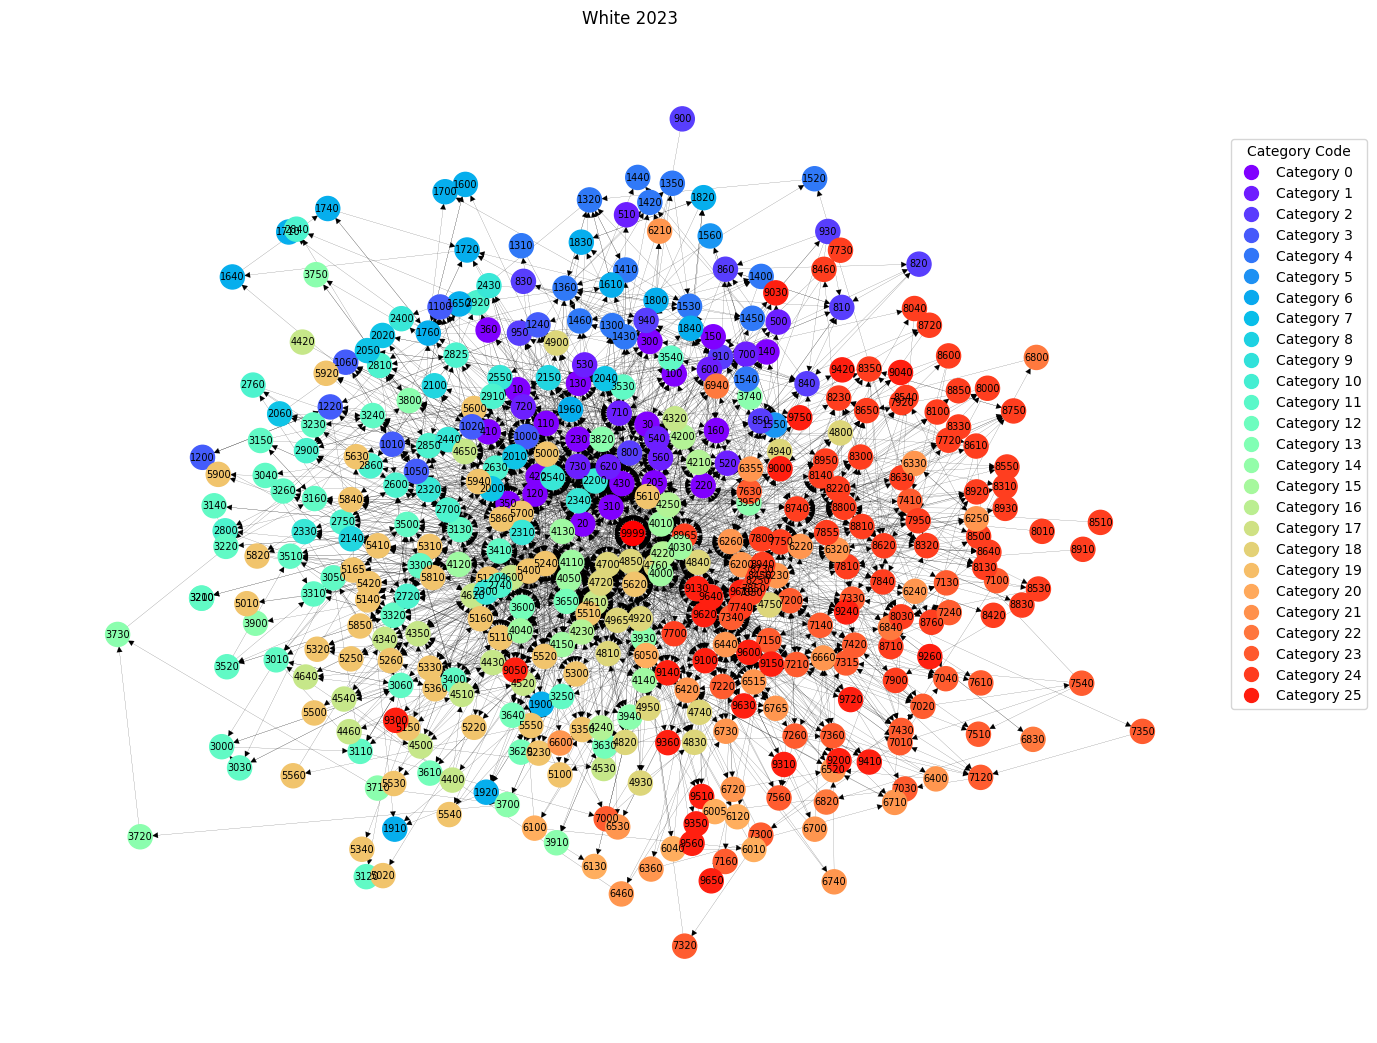

In [15]:
G_100 = create_graph(100, 2023)
plot_graph(G_100, 100)

In [16]:
centrality_100 = calc_centrality_measures(G_100)

In [17]:
top_centralities_100 = get_top_occ_centralities(centrality_100)
top_centralities_100

,degree,weighted_degree,betweenness,closeness,eigenvector,pagerank
0,"Managers, nec (including Postmasters)","Managers, nec (including Postmasters)","Managers, nec (including Postmasters)",NIU,"Managers, nec (including Postmasters)","Managers, nec (including Postmasters)"
1,Customer Service Representatives,Retail Salespersons,Customer Service Representatives,"Managers, nec (including Postmasters)",NIU,NIU
2,Retail Salespersons,Customer Service Representatives,"Assemblers and Fabricators, nec",Customer Service Representatives,Customer Service Representatives,Retail Salespersons
3,Cashiers,Cashiers,Retail Salespersons,First-Line Supervisors of Sales Workers,First-Line Supervisors of Sales Workers,Customer Service Representatives
4,"Assemblers and Fabricators, nec",Driver/Sales Workers and Truck Drivers,Driver/Sales Workers and Truck Drivers,Retail Salespersons,Cashiers,Computer Scientists and Systems Analysts/Netwo...


In [18]:
centrality_wage_100 = combine_centrality_income(100, centrality_100)
centrality_wage_100

,OCC2010,Average_INCWAGE,occ_title,degree,weighted_degree,weighed_in_degree,weighed_out_degree,betweenness,closeness,eigenvector,pagerank
0,10.0,183716.839806,Chief executives and legislators/public admini...,0.052257,0.202962,0.198757,0.206399,0.002912,0.296912,0.031645,0.004103
1,20.0,122494.556025,General and Operations Managers,0.090261,0.263661,0.330568,0.208959,0.013019,0.358013,0.095170,0.005560
2,30.0,121697.212719,"Managers in Marketing, Advertising, and Public...",0.066508,0.239274,0.279855,0.206097,0.004179,0.318727,0.044874,0.004240
3,100.0,76726.649351,Administrative Services Managers,0.028504,0.057110,0.068538,0.047766,0.000379,0.311592,0.034376,0.001436
4,110.0,147607.126126,Computer and Information Systems Managers,0.047506,0.132036,0.080925,0.173824,0.002342,0.296912,0.023517,0.001624
...,...,...,...,...,...,...,...,...,...,...,...
417,9640.0,29657.616279,"Packers and Packagers, Hand",0.073634,0.228526,0.236561,0.221956,0.007467,0.340149,0.070445,0.004033
418,9650.0,81933.333333,Pumping Station Operators,0.002375,0.002567,0.005706,0.000000,0.000000,0.235326,0.002029,0.000627
419,9720.0,26246.774194,Refuse and Recyclable Material Collectors,0.014252,0.016060,0.017755,0.014675,0.000013,0.284520,0.016977,0.000725
420,9750.0,54677.100000,"Material moving workers, nec",0.019002,0.035001,0.021879,0.045729,0.000383,0.273568,0.011772,0.000868


lowest average income: Furniture Finishers (0.00 $)<br>
highest average income: Podiatrists (331,333.33 $)<br>
Most popular/central occupation is Managers. They have the highest weighed in degree but also highest weighed out degree. Also the highest betweenness, pagerank and eigenvector centrality as well as a very high closeness.

In [19]:
centrality_wage_100.sort_values(by='weighed_out_degree')

,OCC2010,Average_INCWAGE,occ_title,degree,weighted_degree,weighed_in_degree,weighed_out_degree,betweenness,closeness,eigenvector,pagerank
421,9999.0,63181.138211,NIU,0.166271,0.296995,0.660256,0.000000,0.000000,0.443043,0.259405,0.017294
166,3900.0,19994.666667,Animal Control,0.002375,0.007659,0.017027,0.000000,0.000000,0.254209,0.005885,0.000680
387,8850.0,41250.000000,Adhesive Bonding Machine Operators and Tenders,0.002375,0.002164,0.004811,0.000000,0.000000,0.259714,0.004931,0.000546
140,3250.0,97592.000000,Veterinarians,0.007126,0.006479,0.014404,0.000000,0.000000,0.288497,0.014647,0.000970
136,3210.0,65000.000000,Recreational Therapists,0.002375,0.002697,0.005997,0.000000,0.000000,0.240552,0.003718,0.000571
...,...,...,...,...,...,...,...,...,...,...,...
399,9130.0,55230.866128,Driver/Sales Workers and Truck Drivers,0.182898,0.555195,0.518433,0.585252,0.048190,0.381308,0.136357,0.010460
205,4720.0,25708.397833,Cashiers,0.199525,0.605932,0.625833,0.589661,0.041493,0.377005,0.163141,0.009192
233,5240.0,51214.061669,Customer Service Representatives,0.263658,0.607364,0.516583,0.681584,0.076171,0.401957,0.206188,0.011055
208,4760.0,48326.440491,Retail Salespersons,0.225653,0.730746,0.635882,0.808304,0.057157,0.383057,0.161667,0.011382


<Axes: >

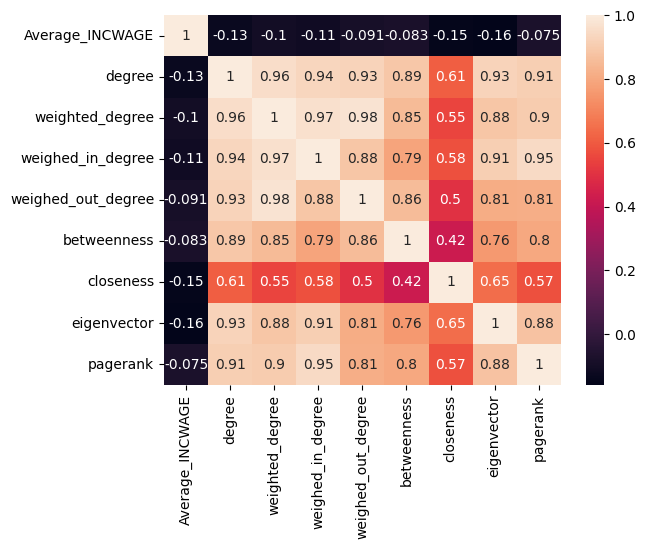

In [20]:
corr = centrality_wage_100[['Average_INCWAGE', 'degree', 'weighted_degree', 'weighed_in_degree', 'weighed_out_degree', 'betweenness', 'closeness', 'eigenvector', 'pagerank']].corr()
sns.heatmap(corr, annot=True)

In [21]:
white_overall = data_df[data_df['RACE'] == 100]
white_overall[(white_overall['OCC2010'] == 430.0) & (white_overall['OCC10LY'] == 430.0)]

,YEAR,SERIAL,CPSID,ASECFLAG,PERNUM,ASECWT,AGE,SEX,RACE,ASIAN,...,OCCLY,OCC10LY,INCWAGE,MIGSTA1,WHYMOVE,MIGRATE1,Category,occ_title,race_comp_all,race_comp_2003
1,1968,35,NaN,NaN,1,1268.58,60,1,100,NaN,...,290.0,430.0,10000,NaN,NaN,1.0,"MANAGEMENT, BUSINESS, SCIENCE, AND ARTS","Managers, nec (including Postmasters)",100,100
2,1968,44,NaN,NaN,1,1230.62,25,1,100,NaN,...,290.0,430.0,7100,NaN,NaN,1.0,"MANAGEMENT, BUSINESS, SCIENCE, AND ARTS","Managers, nec (including Postmasters)",100,100
3,1968,61,NaN,NaN,1,1343.78,62,1,100,NaN,...,290.0,430.0,30000,NaN,NaN,1.0,"MANAGEMENT, BUSINESS, SCIENCE, AND ARTS","Managers, nec (including Postmasters)",100,100
4,1968,62,NaN,NaN,1,1346.78,34,1,100,NaN,...,290.0,430.0,12000,NaN,NaN,1.0,"MANAGEMENT, BUSINESS, SCIENCE, AND ARTS","Managers, nec (including Postmasters)",100,100
5,1968,63,NaN,NaN,1,1440.05,45,1,100,NaN,...,290.0,430.0,15000,NaN,NaN,5.0,"MANAGEMENT, BUSINESS, SCIENCE, AND ARTS","Managers, nec (including Postmasters)",100,100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214005,2023,87975,0.000000e+00,1.0,2,598.16,41,1,100,99.0,...,335.0,430.0,0,99.0,0.0,1.0,"MANAGEMENT, BUSINESS, SCIENCE, AND ARTS","Managers, nec (including Postmasters)",100,100
214006,2023,87997,0.000000e+00,1.0,1,472.89,61,1,100,99.0,...,440.0,430.0,190000,99.0,0.0,1.0,"MANAGEMENT, BUSINESS, SCIENCE, AND ARTS","Managers, nec (including Postmasters)",100,100
214009,2023,88046,2.022030e+13,1.0,1,933.56,55,1,100,99.0,...,440.0,430.0,175000,99.0,0.0,1.0,"MANAGEMENT, BUSINESS, SCIENCE, AND ARTS","Managers, nec (including Postmasters)",100,100
214011,2023,88150,2.022030e+13,1.0,3,755.57,57,1,100,99.0,...,440.0,430.0,80000,99.0,0.0,1.0,"MANAGEMENT, BUSINESS, SCIENCE, AND ARTS","Managers, nec (including Postmasters)",100,100


#### Black

{10: {'category_code': 0, 'Average_INCWAGE': 122314.25, 'Average_INCWAGE_scaled': 0.370200514527845}, 20: {'category_code': 0, 'Average_INCWAGE': 77166.0, 'Average_INCWAGE_scaled': 0.23355326876513316}, 30: {'category_code': 0, 'Average_INCWAGE': 78307.76923076923, 'Average_INCWAGE_scaled': 0.23700898677593593}, 100: {'category_code': 0, 'Average_INCWAGE': 55500.0, 'Average_INCWAGE_scaled': 0.16797820823244553}, 110: {'category_code': 0, 'Average_INCWAGE': 136947.45454545456, 'Average_INCWAGE_scaled': 0.41448987453224745}, 120: {'category_code': 0, 'Average_INCWAGE': 105026.46296296296, 'Average_INCWAGE_scaled': 0.3178767038830598}, 130: {'category_code': 0, 'Average_INCWAGE': 98929.92592592593, 'Average_INCWAGE_scaled': 0.2994247152721729}, 140: {'category_code': 0, 'Average_INCWAGE': 77056.4, 'Average_INCWAGE_scaled': 0.23322154963680383}, 150: {'category_code': 0, 'Average_INCWAGE': 83290.90909090909, 'Average_INCWAGE_scaled': 0.2520911292097733}, 160: {'category_code': 0, 'Average_

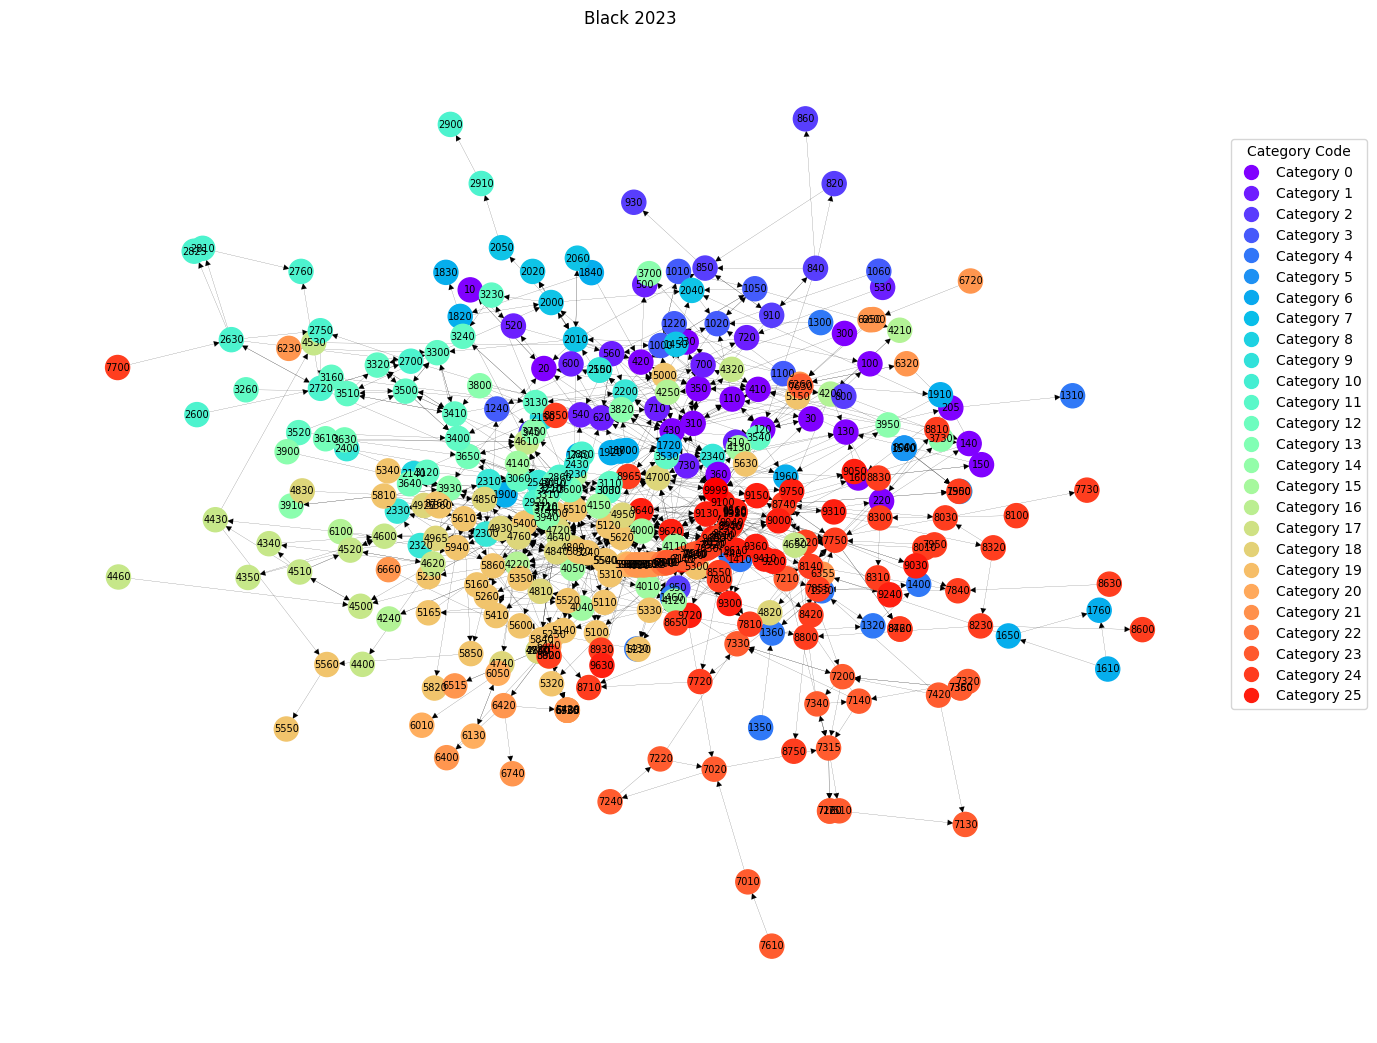

In [22]:
G_200 = create_graph(200, 2023)
plot_graph(G_200, 200)

In [23]:
centrality_200 = calc_centrality_measures(G_200)

In [24]:
top_centralities_200 = get_top_occ_centralities(centrality_200)
top_centralities_200

,degree,weighted_degree,betweenness,closeness,eigenvector,pagerank
0,"Managers, nec (including Postmasters)","Managers, nec (including Postmasters)","Managers, nec (including Postmasters)","Managers, nec (including Postmasters)","Managers, nec (including Postmasters)","Managers, nec (including Postmasters)"
1,Customer Service Representatives,"Nursing, Psychiatric, and Home Health Aides",Customer Service Representatives,NIU,Customer Service Representatives,"Nursing, Psychiatric, and Home Health Aides"
2,"Laborers and Freight, Stock, and Material Move...","Laborers and Freight, Stock, and Material Move...","Laborers and Freight, Stock, and Material Move...",First-Line Supervisors of Sales Workers,Driver/Sales Workers and Truck Drivers,Customer Service Representatives
3,Driver/Sales Workers and Truck Drivers,Customer Service Representatives,Driver/Sales Workers and Truck Drivers,Couriers and Messengers,Stock Clerks and Order Fillers,Driver/Sales Workers and Truck Drivers
4,Cashiers,Driver/Sales Workers and Truck Drivers,"Nursing, Psychiatric, and Home Health Aides","Human Resources, Training, and Labor Relations...","Laborers and Freight, Stock, and Material Move...",Elementary and Middle School Teachers


In [25]:
centrality_wage_200 = combine_centrality_income(200, centrality_200)
centrality_wage_200

,OCC2010,Average_INCWAGE,occ_title,degree,weighted_degree,weighed_in_degree,weighed_out_degree,betweenness,closeness,eigenvector,pagerank
0,10.0,122314.250000,Chief executives and legislators/public admini...,0.008065,0.027160,0.034137,0.019664,0.000414,0.122934,0.004240,0.003025
1,20.0,77166.000000,General and Operations Managers,0.018817,0.095795,0.130717,0.059224,0.003149,0.154827,0.027087,0.004731
2,30.0,78307.769231,"Managers in Marketing, Advertising, and Public...",0.013441,0.082443,0.087302,0.075709,0.003156,0.152844,0.055003,0.005127
3,100.0,55500.000000,Administrative Services Managers,0.010753,0.021136,0.031787,0.010175,0.000200,0.126365,0.010330,0.002427
4,110.0,136947.454545,Computer and Information Systems Managers,0.021505,0.061946,0.070808,0.051770,0.004258,0.166404,0.071975,0.003252
...,...,...,...,...,...,...,...,...,...,...,...
357,9630.0,25000.000000,Machine Feeders and Offbearers,0.002688,0.003004,0.005990,0.000000,0.000000,0.127022,0.023881,0.000808
358,9640.0,36348.413793,"Packers and Packagers, Hand",0.043011,0.365919,0.314514,0.407684,0.008750,0.159918,0.152590,0.004807
359,9720.0,26200.000000,Refuse and Recyclable Material Collectors,0.010753,0.029858,0.012046,0.046636,0.000595,0.129608,0.025261,0.000911
360,9750.0,40400.000000,"Material moving workers, nec",0.005376,0.019581,0.039048,0.000000,0.000000,0.141610,0.024083,0.001838


* lowest average income: Glaziers (0.00 $)
* highest average income: Dentists (330,400.00 $)
Transitioning to Managers is very popular. Where Laborers and Freight, Stock, and Material Movers is most central when it comes to leaving this occupation.

In [26]:
centrality_wage_200.sort_values(by = 'betweenness')

,OCC2010,Average_INCWAGE,occ_title,degree,weighted_degree,weighed_in_degree,weighed_out_degree,betweenness,closeness,eigenvector,pagerank
361,9999.0,53126.650000,NIU,0.037634,0.191615,0.382112,0.000000,0.000000,0.192488,2.099212e-01,0.010009
268,6940.0,75000.000000,"Extraction workers, nec",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.697745e-26,0.000749
267,6840.0,50000.000000,Mining Machine Operators,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.697745e-26,0.000749
132,3610.0,96000.000000,Occupational Therapy Assistants and Aides,0.002688,0.015793,0.000000,0.030926,0.000000,0.000000,4.697745e-26,0.000749
133,3630.0,35498.000000,Massage Therapists,0.005376,0.009045,0.000000,0.017711,0.000000,0.000000,4.697745e-26,0.000749
...,...,...,...,...,...,...,...,...,...,...,...
131,3600.0,32967.375494,"Nursing, Psychiatric, and Home Health Aides",0.056452,0.834106,0.786922,0.860582,0.039679,0.176707,1.178937e-01,0.021836
341,9130.0,49277.840909,Driver/Sales Workers and Truck Drivers,0.075269,0.729417,0.785955,0.656539,0.040384,0.173898,2.469416e-01,0.017483
356,9620.0,32699.420000,"Laborers and Freight, Stock, and Material Move...",0.088710,0.805488,0.587869,1.000000,0.046297,0.171177,2.236614e-01,0.010619
207,5240.0,40042.565476,Customer Service Representatives,0.110215,0.759935,0.705457,0.795338,0.063828,0.178873,2.528376e-01,0.020539


<Axes: >

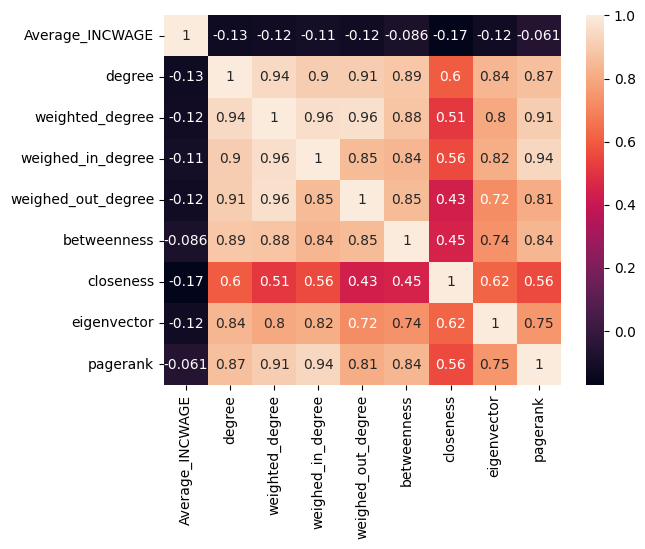

In [27]:
corr = centrality_wage_200[['Average_INCWAGE', 'degree', 'weighted_degree','weighed_in_degree', 'weighed_out_degree', 'betweenness', 'closeness', 'eigenvector', 'pagerank']].corr()
sns.heatmap(corr, annot=True)

#### American Indian/Aleut/Eskimo

{10: {'category_code': 0, 'Average_INCWAGE': 84500.0, 'Average_INCWAGE_scaled': 0.16899999999999998}, 20: {'category_code': 0, 'Average_INCWAGE': 40000.0, 'Average_INCWAGE_scaled': 0.08}, 30: {'category_code': 0, 'Average_INCWAGE': 62300.0, 'Average_INCWAGE_scaled': 0.12459999999999999}, 100: {'category_code': 0, 'Average_INCWAGE': 146333.33333333334, 'Average_INCWAGE_scaled': 0.2926666666666667}, 110: {'category_code': 0, 'Average_INCWAGE': 100000.0, 'Average_INCWAGE_scaled': 0.19999999999999998}, 120: {'category_code': 0, 'Average_INCWAGE': 89000.0, 'Average_INCWAGE_scaled': 0.178}, 130: {'category_code': 0, 'Average_INCWAGE': 130565.0, 'Average_INCWAGE_scaled': 0.26113}, 150: {'category_code': 0, 'Average_INCWAGE': 50000.0, 'Average_INCWAGE_scaled': 0.09999999999999999}, 160: {'category_code': 0, 'Average_INCWAGE': 90666.66666666667, 'Average_INCWAGE_scaled': 0.18133333333333335}, 205: {'category_code': 0, 'Average_INCWAGE': 12200.0, 'Average_INCWAGE_scaled': 0.024399999999999998}, 

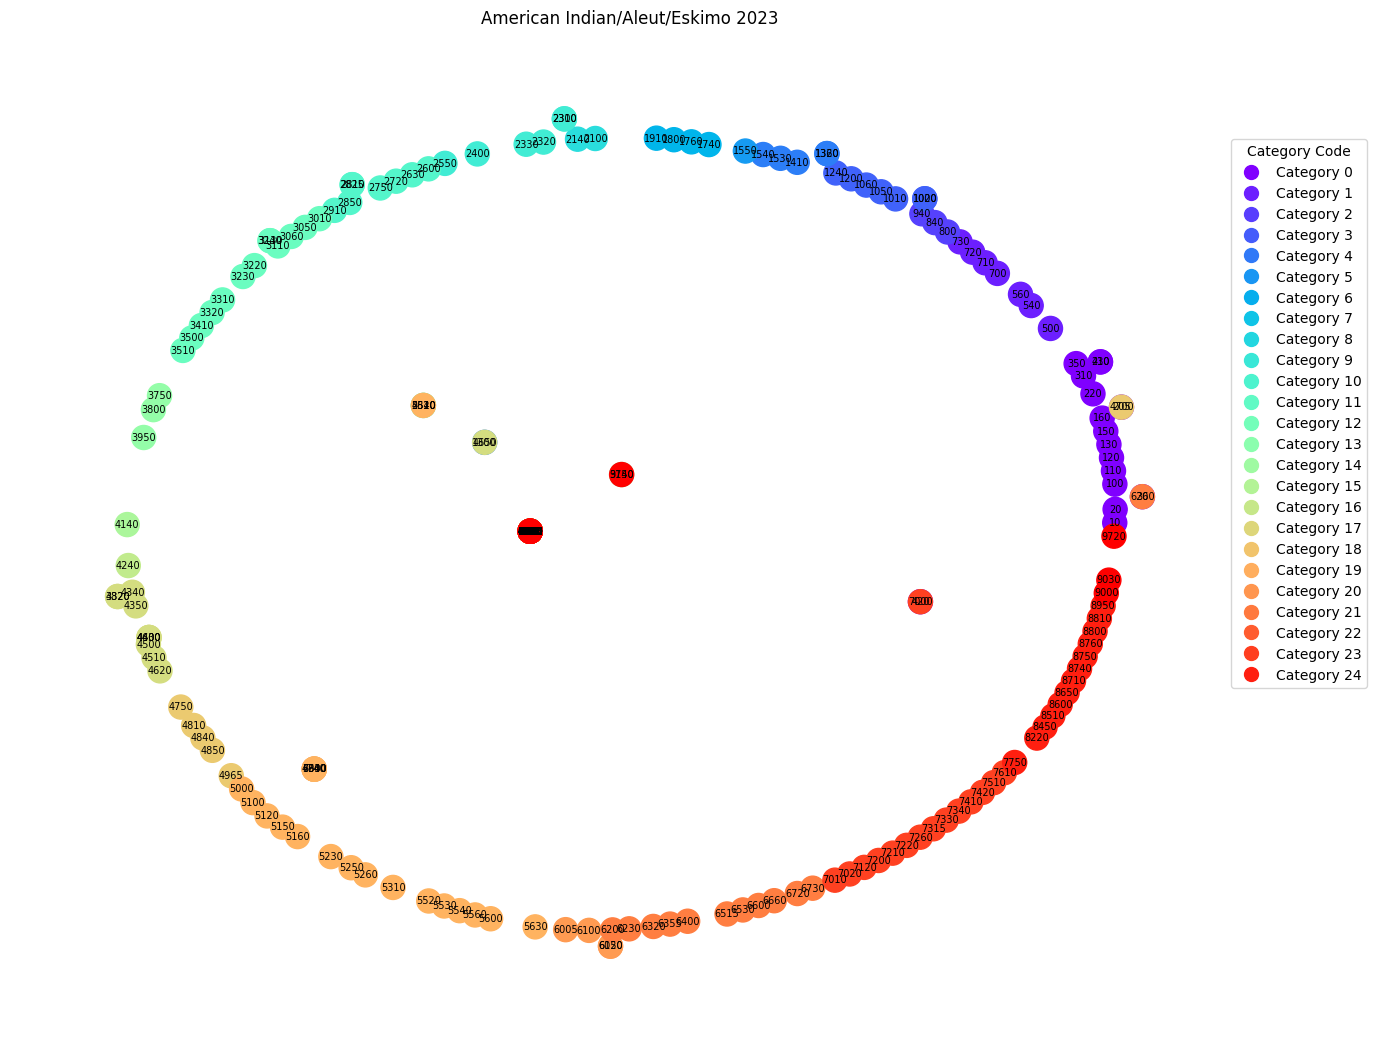

In [28]:
G_300 = create_graph(300, 2023)
plot_graph(G_300, 300)

In [29]:
centrality_300 = calc_centrality_measures(G_300, max_iter = 500)

In [30]:
top_centralities_300 = get_top_occ_centralities(centrality_300)
top_centralities_300

,degree,weighted_degree,betweenness,closeness,eigenvector,pagerank
0,Driver/Sales Workers and Truck Drivers,Stock Clerks and Order Fillers,"Combined Food Preparation and Serving Workers,...","Shipping, Receiving, and Traffic Clerks","Shipping, Receiving, and Traffic Clerks","Shipping, Receiving, and Traffic Clerks"
1,"Managers, nec (including Postmasters)",Customer Service Representatives,Waiters and Waitresses,"Financial Clerks, nec","Combined Food Preparation and Serving Workers,...","Food Servers, Nonrestaurant"
2,Customer Service Representatives,"Cement Masons, Concrete Finishers, and Terrazz...","Office and administrative support workers, nec",Driver/Sales Workers and Truck Drivers,Food Preparation Workers,"Combined Food Preparation and Serving Workers,..."
3,"Combined Food Preparation and Serving Workers,...","Host and Hostesses, Restaurant, Lounge, and Co...",Stock Clerks and Order Fillers,"Combined Food Preparation and Serving Workers,...","Office and administrative support workers, nec","Financial Clerks, nec"
4,Waiters and Waitresses,Other production workers including semiconduct...,"Office Clerks, General","Food Servers, Nonrestaurant","Office Clerks, General","Office Clerks, General"


In [31]:
centrality_wage_300 = combine_centrality_income(300, centrality_300)
centrality_wage_300

,OCC2010,Average_INCWAGE,occ_title,degree,weighted_degree,weighed_in_degree,weighed_out_degree,betweenness,closeness,eigenvector,pagerank
0,10.0,84500.000000,Chief executives and legislators/public admini...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.772086e-126,0.003105
1,20.0,40000.000000,General and Operations Managers,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.772086e-126,0.003105
2,30.0,62300.000000,"Managers in Marketing, Advertising, and Public...",0.004310,0.031316,0.048562,0.000000,0.000000,0.004310,1.133783e-123,0.005745
3,100.0,146333.333333,Administrative Services Managers,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.772086e-126,0.003105
4,110.0,100000.000000,Computer and Information Systems Managers,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.772086e-126,0.003105
...,...,...,...,...,...,...,...,...,...,...,...
220,9420.0,43902.000000,"Transportation workers, nec",0.004310,0.076876,0.119212,0.000000,0.000000,0.017985,7.940852e-03,0.004585
221,9600.0,35000.000000,Industrial Truck and Tractor Operators,0.008621,0.387296,0.000000,0.653318,0.000000,0.000000,2.772086e-126,0.003105
222,9620.0,35675.125000,"Laborers and Freight, Stock, and Material Move...",0.012931,0.311860,0.040116,0.482428,0.000411,0.008621,3.054174e-03,0.005042
223,9640.0,24192.250000,"Packers and Packagers, Hand",0.017241,0.470236,0.598026,0.142691,0.000597,0.011494,3.054174e-03,0.007448


* lowest average income: Photographers, Musicians, Roofers, ... (0.00 $)
* highest average income: Economists and Market researchers (50,000.00 $)
Very popular occupation to transition to are Stock Clerks and Order Fillers. Very common to leave is the occupation Retail Salespersons. 

In [32]:
centrality_wage_300.sort_values(by = 'weighed_out_degree')

,OCC2010,Average_INCWAGE,occ_title,degree,weighted_degree,weighed_in_degree,weighed_out_degree,betweenness,closeness,eigenvector,pagerank
0,10.0,84500.000000,Chief executives and legislators/public admini...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.772086e-126,0.003105
138,5230.0,40000.000000,"Credit Authorizers, Checkers, and Clerks",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.772086e-126,0.003105
140,5250.0,28000.000000,"Eligibility Interviewers, Government Programs",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.772086e-126,0.003105
141,5260.0,47000.000000,File Clerks,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.772086e-126,0.003105
142,5300.0,28500.000000,"Hotel, Motel, and Resort Desk Clerks",0.004310,0.060474,0.093777,0.000000,0.000000,0.004310,1.133783e-123,0.004063
...,...,...,...,...,...,...,...,...,...,...,...
139,5240.0,34693.000000,Customer Service Representatives,0.025862,0.692884,0.308393,0.833331,0.000448,0.012931,3.054174e-03,0.010140
214,8965.0,41498.000000,Other production workers including semiconduct...,0.017241,0.621918,0.137998,0.898980,0.000336,0.006466,1.832504e-03,0.007441
95,4000.0,28805.066667,Chefs and Cooks,0.017241,0.593855,0.083157,0.911296,0.000261,0.004310,1.133783e-123,0.005745
48,2000.0,45600.000000,Counselors,0.012931,0.587376,0.000000,0.990825,0.000000,0.000000,2.772086e-126,0.003105


<Axes: >

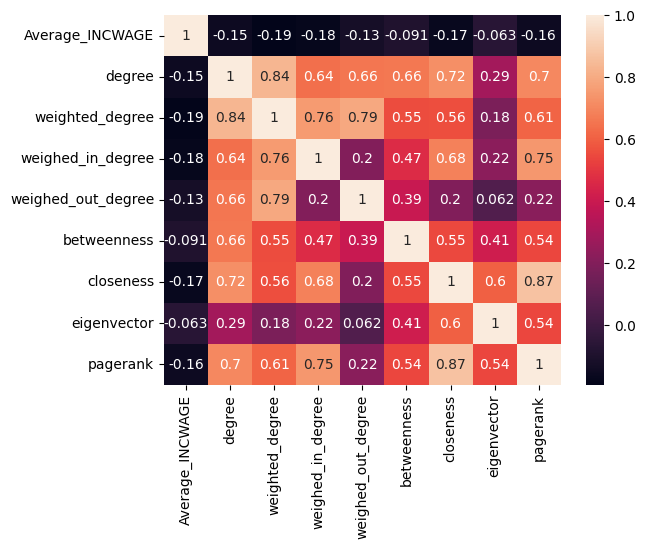

In [33]:
corr = centrality_wage_300[['Average_INCWAGE', 'degree', 'weighted_degree','weighed_in_degree', 'weighed_out_degree', 'betweenness', 'closeness', 'eigenvector', 'pagerank']].corr()
sns.heatmap(corr, annot=True)

#### White-Black

{10: {'category_code': 0, 'Average_INCWAGE': 102833.33333333333, 'Average_INCWAGE_scaled': 0.18231583662728112}, 20: {'category_code': 0, 'Average_INCWAGE': 70000.0, 'Average_INCWAGE_scaled': 0.12410478344158521}, 30: {'category_code': 0, 'Average_INCWAGE': 57072.0, 'Average_INCWAGE_scaled': 0.10118440286540216}, 100: {'category_code': 0, 'Average_INCWAGE': 72000.0, 'Average_INCWAGE_scaled': 0.12765063439705907}, 110: {'category_code': 0, 'Average_INCWAGE': 225000.0, 'Average_INCWAGE_scaled': 0.3989082324908096}, 120: {'category_code': 0, 'Average_INCWAGE': 51500.0, 'Average_INCWAGE_scaled': 0.09130566210345198}, 130: {'category_code': 0, 'Average_INCWAGE': 38000.0, 'Average_INCWAGE_scaled': 0.0673711681540034}, 220: {'category_code': 0, 'Average_INCWAGE': 290000.0, 'Average_INCWAGE_scaled': 0.5141483885437101}, 230: {'category_code': 0, 'Average_INCWAGE': 68400.0, 'Average_INCWAGE_scaled': 0.12126810267720611}, 310: {'category_code': 0, 'Average_INCWAGE': 32666.666666666668, 'Average_

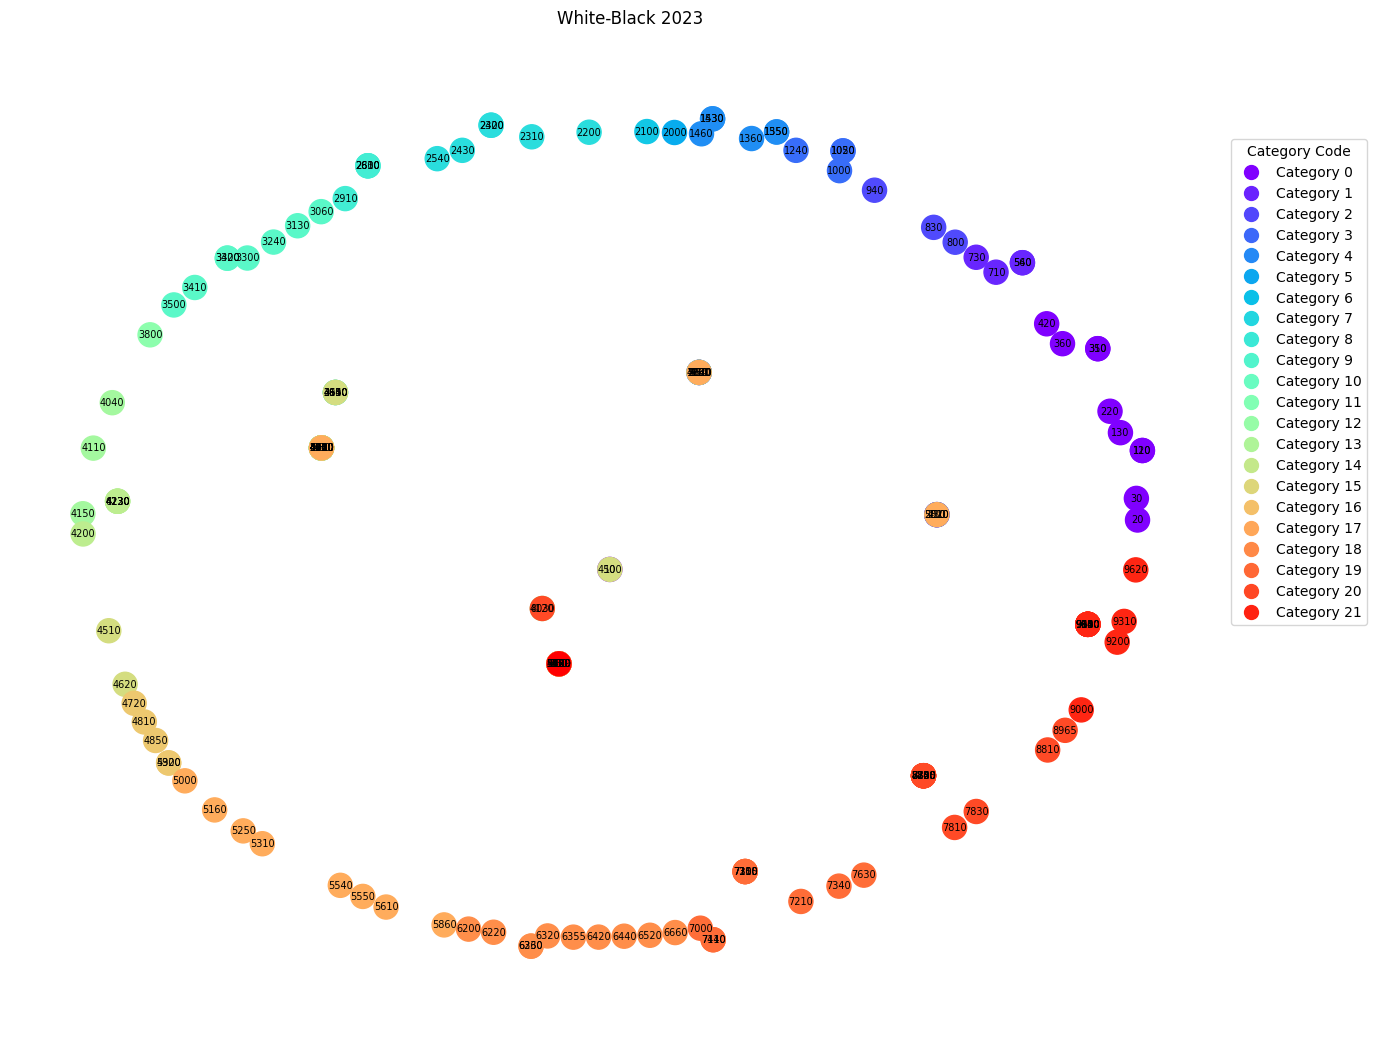

In [34]:
G_801 = create_graph(801, 2023)
plot_graph(G_801, 801)

In [35]:
centrality_801 = calc_centrality_measures(G_801)

In [36]:
top_centralities_801 = get_top_occ_centralities(centrality_801)
top_centralities_801

,degree,weighted_degree,betweenness,closeness,eigenvector,pagerank
0,Chefs and Cooks,Customer Service Representatives,Chefs and Cooks,Receptionists and Information Clerks,"Compliance Officers, Except Agriculture","Compliance Officers, Except Agriculture"
1,Customer Service Representatives,Driver/Sales Workers and Truck Drivers,Preschool and Kindergarten Teachers,"Metal workers and plastic workers, nec","Claims Adjusters, Appraisers, Examiners, and I...","Claims Adjusters, Appraisers, Examiners, and I..."
2,"Combined Food Preparation and Serving Workers,...",Grounds Maintenance Workers,Childcare Workers,"Combined Food Preparation and Serving Workers,...","Entertainers and Performers, Sports and Relate...",Bakers
3,"Metal workers and plastic workers, nec",Chefs and Cooks,Customer Service Representatives,Bakers,Security Guards and Gaming Surveillance Officers,"Metal workers and plastic workers, nec"
4,Driver/Sales Workers and Truck Drivers,Packaging and Filling Machine Operators and Te...,"Personal Appearance Workers, nec",Other Teachers and Instructors,First-Line Supervisors of Food Preparation and...,Couriers and Messengers


In [37]:
centrality_wage_801 = combine_centrality_income(801, centrality_801)
centrality_wage_801

,OCC2010,Average_INCWAGE,occ_title,degree,weighted_degree,weighed_in_degree,weighed_out_degree,betweenness,closeness,eigenvector,pagerank
0,10.0,102833.333333,Chief executives and legislators/public admini...,0.006211,0.153496,0.000000,0.205097,0.0,0.000000,1.646361e-10,0.004232
1,20.0,70000.000000,General and Operations Managers,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,1.646361e-10,0.004232
2,30.0,57072.000000,"Managers in Marketing, Advertising, and Public...",0.000000,0.000000,0.000000,0.000000,0.0,0.000000,1.646361e-10,0.004232
3,100.0,72000.000000,Administrative Services Managers,0.006211,0.168983,0.000000,0.225789,0.0,0.000000,1.646361e-10,0.004232
4,110.0,225000.000000,Computer and Information Systems Managers,0.006211,0.241023,0.000000,0.322048,0.0,0.000000,1.646361e-10,0.004232
...,...,...,...,...,...,...,...,...,...,...,...
139,9600.0,33042.833333,Industrial Truck and Tractor Operators,0.006211,0.227886,0.364314,0.000000,0.0,0.008282,8.709251e-08,0.006030
140,9610.0,39999.500000,Cleaners of Vehicles and Equipment,0.012422,0.505975,0.808885,0.000000,0.0,0.013975,9.236087e-08,0.010764
141,9620.0,22370.000000,"Laborers and Freight, Stock, and Material Move...",0.000000,0.000000,0.000000,0.000000,0.0,0.000000,1.646361e-10,0.004232
142,9640.0,36333.333333,"Packers and Packagers, Hand",0.006211,0.148844,0.237952,0.000000,0.0,0.006211,5.432992e-09,0.005471


* lowest average income: First-Line Supervisors of Construction Trades...; Other Installation... (0.00 $)
* highest average income: Bakers (564,039.5 $)

In [38]:
centrality_wage_801[centrality_wage_801['OCC2010'] == 430.0]

,OCC2010,Average_INCWAGE,occ_title,degree,weighted_degree,weighed_in_degree,weighed_out_degree,betweenness,closeness,eigenvector,pagerank
14,430.0,87825.0,"Managers, nec (including Postmasters)",0.018634,0.391996,0.245389,0.318676,0.000155,0.008282,8.709251e-08,0.006155


In [39]:
centrality_wage_801.sort_values(by='pagerank')

,OCC2010,Average_INCWAGE,occ_title,degree,weighted_degree,weighed_in_degree,weighed_out_degree,betweenness,closeness,eigenvector,pagerank
0,10.0,102833.333333,Chief executives and legislators/public admini...,0.006211,0.153496,0.000000,0.205097,0.000000,0.000000,1.646361e-10,0.004232
111,6355.0,115000.000000,Electricians,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.646361e-10,0.004232
112,6420.0,37500.000000,"Painters, Construction and Maintenance",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.646361e-10,0.004232
61,3800.0,100000.000000,"Sheriffs, Bailiffs, Correctional Officers, and...",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.646361e-10,0.004232
59,3600.0,31666.666667,"Nursing, Psychiatric, and Home Health Aides",0.018634,0.549618,0.000000,0.734383,0.000000,0.000000,1.646361e-10,0.004232
...,...,...,...,...,...,...,...,...,...,...,...
99,5510.0,32117.000000,Couriers and Messengers,0.006211,0.110336,0.176390,0.000000,0.000000,0.012940,2.536878e-06,0.016989
130,8220.0,37586.666667,"Metal workers and plastic workers, nec",0.024845,0.492638,0.412405,0.313558,0.000155,0.019876,9.762922e-08,0.017339
124,7800.0,564039.500000,Bakers,0.006211,0.234669,0.375158,0.000000,0.000000,0.015528,1.067007e-06,0.018971
15,540.0,80000.000000,"Claims Adjusters, Appraisers, Examiners, and I...",0.012422,0.387058,0.340199,0.232835,0.000000,0.006211,7.071068e-01,0.028018


<Axes: >

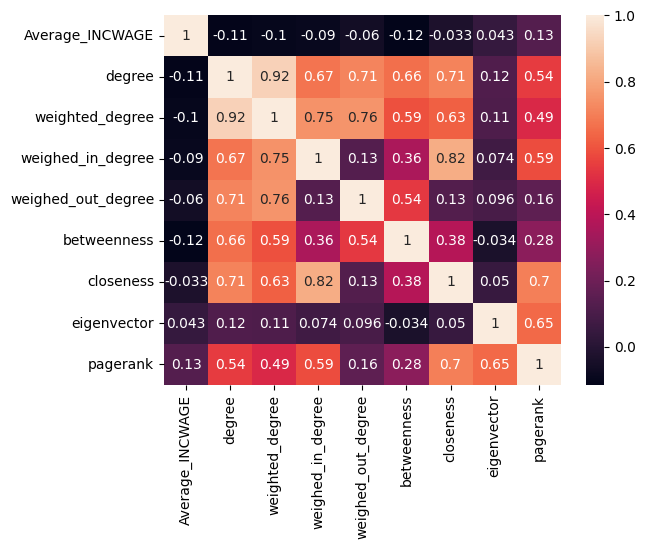

In [40]:
corr = centrality_wage_801[['Average_INCWAGE', 'degree', 'weighted_degree','weighed_in_degree', 'weighed_out_degree', 'betweenness', 'closeness', 'eigenvector', 'pagerank']].corr()
sns.heatmap(corr, annot=True)

### Asian only

{10: {'category_code': 0, 'Average_INCWAGE': 183010.69642857142, 'Average_INCWAGE_scaled': 0.4575267410714286}, 20: {'category_code': 0, 'Average_INCWAGE': 136416.7741935484, 'Average_INCWAGE_scaled': 0.341041935483871}, 30: {'category_code': 0, 'Average_INCWAGE': 126867.44444444444, 'Average_INCWAGE_scaled': 0.3171686111111111}, 100: {'category_code': 0, 'Average_INCWAGE': 60927.0, 'Average_INCWAGE_scaled': 0.15231750000000002}, 110: {'category_code': 0, 'Average_INCWAGE': 144403.0, 'Average_INCWAGE_scaled': 0.36100750000000004}, 120: {'category_code': 0, 'Average_INCWAGE': 157231.15384615384, 'Average_INCWAGE_scaled': 0.3930778846153846}, 130: {'category_code': 0, 'Average_INCWAGE': 124666.66666666667, 'Average_INCWAGE_scaled': 0.3116666666666667}, 140: {'category_code': 0, 'Average_INCWAGE': 131572.22222222222, 'Average_INCWAGE_scaled': 0.32893055555555556}, 150: {'category_code': 0, 'Average_INCWAGE': 81375.0, 'Average_INCWAGE_scaled': 0.20343750000000002}, 160: {'category_code': 0

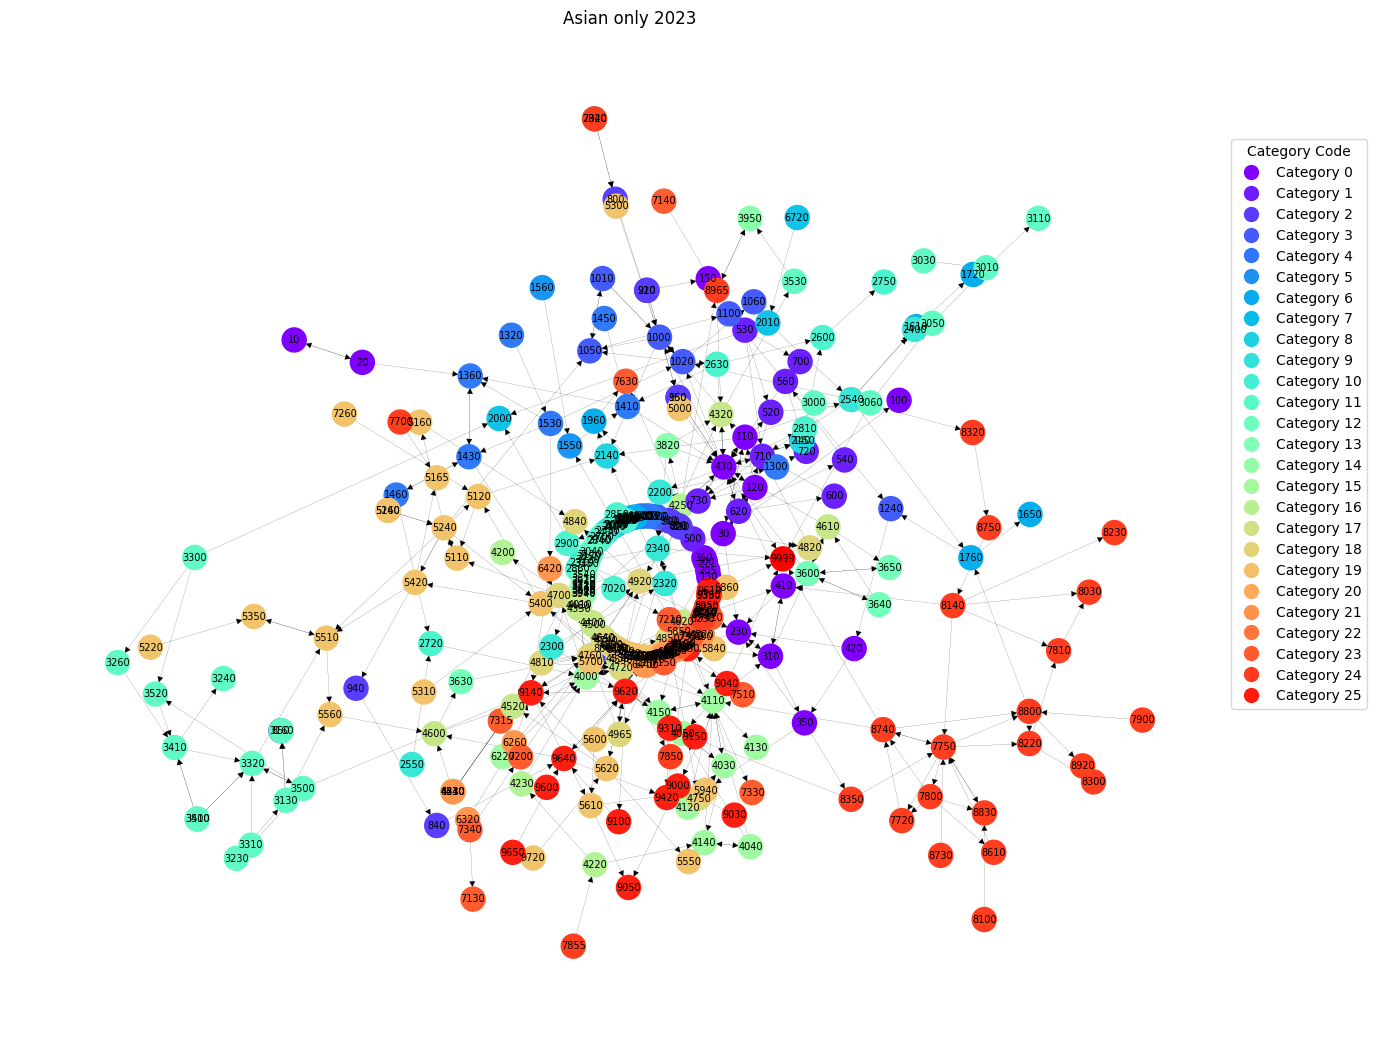

In [41]:
G_651 = create_graph(651, 2023)
plot_graph(G_651, 651)

In [42]:
centrality_651 = calc_centrality_measures(G_651)
top_centralities_651 = get_top_occ_centralities(centrality_651)
top_centralities_651

,degree,weighted_degree,betweenness,closeness,eigenvector,pagerank
0,"Managers, nec (including Postmasters)","Managers, nec (including Postmasters)","Managers, nec (including Postmasters)",Real Estate Brokers and Sales Agents,"Managers, nec (including Postmasters)",Retail Salespersons
1,Waiters and Waitresses,"Software Developers, Applications and Systems ...",Retail Salespersons,Retail Salespersons,"Combined Food Preparation and Serving Workers,...",Waiters and Waitresses
2,Cashiers,Computer Scientists and Systems Analysts/Netwo...,Food Service and Lodging Managers,Cashiers,Computer Scientists and Systems Analysts/Netwo...,"Managers, nec (including Postmasters)"
3,"Laborers and Freight, Stock, and Material Move...",Waiters and Waitresses,Waiters and Waitresses,Taxi Drivers and Chauffeurs,Real Estate Brokers and Sales Agents,Food Service and Lodging Managers
4,Retail Salespersons,"Nursing, Psychiatric, and Home Health Aides",Cashiers,"Combined Food Preparation and Serving Workers,...",Other Business Operations and Management Speci...,Food Preparation Workers


In [43]:
centrality_wage_651 = combine_centrality_income(651, centrality_651)
centrality_wage_651

,OCC2010,Average_INCWAGE,occ_title,degree,weighted_degree,weighed_in_degree,weighed_out_degree,betweenness,closeness,eigenvector,pagerank
0,10.0,183010.696429,Chief executives and legislators/public admini...,0.006061,0.079233,0.067390,0.090492,0.000000,0.003030,1.671964e-20,0.002598
1,20.0,136416.774194,General and Operations Managers,0.009091,0.106240,0.095185,0.116750,0.001234,0.003030,1.671964e-20,0.003278
2,30.0,126867.444444,"Managers in Marketing, Advertising, and Public...",0.024242,0.292926,0.259341,0.324855,0.009083,0.069796,8.905410e-02,0.003189
3,100.0,60927.000000,Administrative Services Managers,0.003030,0.032229,0.066129,0.000000,0.000000,0.061160,2.734888e-02,0.001594
4,110.0,144403.000000,Computer and Information Systems Managers,0.021212,0.220352,0.178243,0.260385,0.022377,0.082454,1.642890e-01,0.003022
...,...,...,...,...,...,...,...,...,...,...,...
311,9600.0,51400.000000,Industrial Truck and Tractor Operators,0.003030,0.022036,0.000000,0.042986,0.000000,0.000000,1.160158e-37,0.001069
312,9610.0,23720.000000,Cleaners of Vehicles and Equipment,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.160158e-37,0.001069
313,9620.0,36186.277778,"Laborers and Freight, Stock, and Material Move...",0.039394,0.438785,0.299463,0.571238,0.033037,0.098044,7.787990e-02,0.009604
314,9640.0,36633.208333,"Packers and Packagers, Hand",0.021212,0.241054,0.336973,0.149864,0.008454,0.082763,3.145161e-02,0.006697


* lowest average income: Jewelers and Precious Stone and Metal Workers; Television, Video; ... (0.00 $)
* highest average income: Podiatrists (400,000.00 $)

In [57]:
centrality_wage_651.sort_values(by='Average_INCWAGE')

,OCC2010,Average_INCWAGE,occ_title,degree,weighted_degree,weighed_in_degree,weighed_out_degree,betweenness,closeness,eigenvector,pagerank
290,8750.0,0.000000,Jewelers and Precious Stone and Metal Workers,0.006061,0.029891,0.017832,0.041356,0.008340,0.054140,4.758433e-03,0.002428
109,2920.0,0.000000,"Television, Video, and Motion Picture Camera O...",0.003030,0.031053,0.000000,0.060574,0.000000,0.000000,1.160158e-37,0.001069
267,7510.0,0.000000,"Coin, Vending, and Amusement Machine Servicers...",0.003030,0.036593,0.000000,0.071382,0.000000,0.000000,1.160158e-37,0.001069
96,2550.0,2000.000000,"Education, Training, and Library Workers, nec",0.003030,0.029008,0.000000,0.056585,0.000000,0.000000,1.160158e-37,0.001069
102,2760.0,2000.000000,"Entertainers and Performers, Sports and Relate...",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.160158e-37,0.001069
...,...,...,...,...,...,...,...,...,...,...,...
84,2100.0,236049.666667,"Lawyers, and judges, magistrates, and other ju...",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.160158e-37,0.001069
115,3060.0,243655.434783,Physicians and Surgeons,0.012121,0.102115,0.100658,0.103500,0.004162,0.070875,3.020106e-02,0.002409
104,2840.0,250000.000000,Technical Writers,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.160158e-37,0.001069
38,900.0,290000.000000,Financial Examiners,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.160158e-37,0.001069


<Axes: >

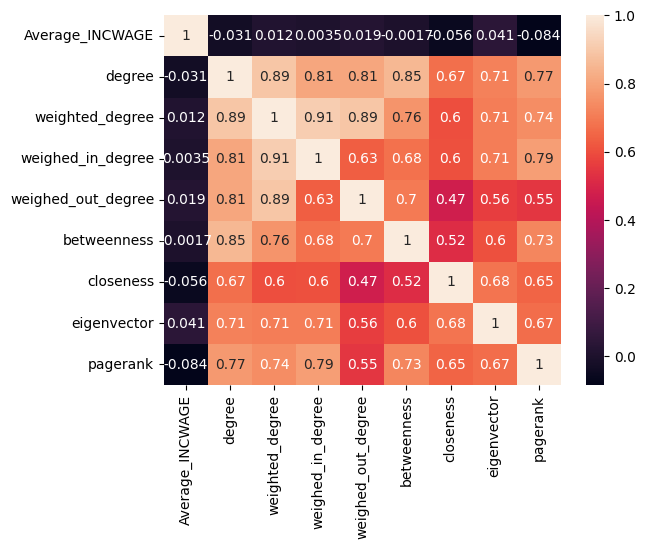

In [45]:
corr = centrality_wage_651[['Average_INCWAGE', 'degree', 'weighted_degree','weighed_in_degree', 'weighed_out_degree', 'betweenness', 'closeness', 'eigenvector', 'pagerank']].corr()
sns.heatmap(corr, annot=True)

# Combine measures

In [46]:
def get_most_central_occs(centrality_wage: pd.DataFrame, race, measures):
    most_central_occ = dict()
    highest_occ = []

    for measure in measures:
        if measure == 'closeness':
            highest_occ.append(centrality_wage.sort_values(by=measure).head(1)['occ_title'].item())
        else:
            highest_occ.append(centrality_wage.sort_values(by=measure).tail(1)['occ_title'].item())

    most_central_occ.update({race: highest_occ})

    return most_central_occ

In [47]:
def get_least_central_occs(centrality_wage: pd.DataFrame, race, measures):
    least_central_occ = dict()
    lowest_occ = []

    for measure in measures:
        if measure == 'closeness':
            lowest_occ.append(centrality_wage.sort_values(by=measure).tail(1)['occ_title'].item())
        else:
            lowest_occ.append(centrality_wage.sort_values(by=measure).head(1)['occ_title'].item())

    least_central_occ.update({race: lowest_occ})

    return least_central_occ

In [48]:
measures = ['degree', 'weighted_degree','weighed_in_degree', 'weighed_out_degree', 'betweenness', 'closeness', 'eigenvector', 'pagerank']

most_central_occ = get_most_central_occs(centrality_wage_100, 100, measures)
most_central_occ.update(get_most_central_occs(centrality_wage_200, 200, measures))
most_central_occ.update(get_most_central_occs(centrality_wage_300, 300, measures))
most_central_occ.update(get_most_central_occs(centrality_wage_801, 801, measures))
most_central_occ.update(get_most_central_occs(centrality_wage_651, 651, measures))

In [49]:
least_central_occ = get_least_central_occs(centrality_wage_100, 100, measures)
least_central_occ.update(get_least_central_occs(centrality_wage_200, 200, measures))
least_central_occ.update(get_least_central_occs(centrality_wage_300, 300, measures))
least_central_occ.update(get_least_central_occs(centrality_wage_801, 801, measures))
least_central_occ.update(get_least_central_occs(centrality_wage_651, 651, measures))

In [50]:
most_central_occ = pd.DataFrame.from_dict(most_central_occ, orient='index')
most_central_occ.columns = measures

least_central_occ = pd.DataFrame.from_dict(least_central_occ, orient='index')
least_central_occ.columns = measures

In [51]:
least_central_occ

,degree,weighted_degree,weighed_in_degree,weighed_out_degree,betweenness,closeness,eigenvector,pagerank
100,Prepress Technicians and Workers,Tire Builders,"Electrical and electronics repairers, transpor...",NIU,NIU,NIU,Prepress Technicians and Workers,Food Cooking Machine Operators and Tenders
200,"Transportation workers, nec",First-Line Supervisors of Construction Trades ...,Locomotive Engineers and Operators,NIU,NIU,"Managers, nec (including Postmasters)",Helpers--Production Workers,Occupational Therapy Assistants and Aides
300,Chief executives and legislators/public admini...,Chief executives and legislators/public admini...,Chief executives and legislators/public admini...,Chief executives and legislators/public admini...,Chief executives and legislators/public admini...,"Shipping, Receiving, and Traffic Clerks",Chief executives and legislators/public admini...,Chief executives and legislators/public admini...
801,"Pipelayers, Plumbers, Pipefitters, and Steamfi...",Electricians,Chief executives and legislators/public admini...,NIU,Chief executives and legislators/public admini...,Receptionists and Information Clerks,Chief executives and legislators/public admini...,Chief executives and legislators/public admini...
651,Occupational Therapy Assistants and Aides,Mining Machine Operators,First-Line Supervisors of Police and Detectives,NIU,Chief executives and legislators/public admini...,Real Estate Brokers and Sales Agents,Fishing and hunting workers,"Medical, Dental, and Ophthalmic Laboratory Tec..."


In [52]:
centrality_wage_801[centrality_wage_801['OCC2010'] == 430.0]

,OCC2010,Average_INCWAGE,occ_title,degree,weighted_degree,weighed_in_degree,weighed_out_degree,betweenness,closeness,eigenvector,pagerank
14,430.0,87825.0,"Managers, nec (including Postmasters)",0.018634,0.391996,0.245389,0.318676,0.000155,0.008282,8.709251e-08,0.006155


In [53]:
centrality_wage_100[centrality_wage_100['OCC2010'] == 430.0]

,OCC2010,Average_INCWAGE,occ_title,degree,weighted_degree,weighed_in_degree,weighed_out_degree,betweenness,closeness,eigenvector,pagerank
19,430.0,91239.959147,"Managers, nec (including Postmasters)",0.342043,1.0,1.0,1.0,0.121808,0.436065,0.295903,0.021086


In [54]:
centrality_wage_200[centrality_wage_200['OCC2010'] == 430.0]

,OCC2010,Average_INCWAGE,occ_title,degree,weighted_degree,weighed_in_degree,weighed_out_degree,betweenness,closeness,eigenvector,pagerank
19,430.0,88297.025641,"Managers, nec (including Postmasters)",0.120968,1.0,1.0,0.976196,0.078924,0.194797,0.27041,0.028371


In [55]:
centrality_wage_300[centrality_wage_300['OCC2010'] == 430.0]

,OCC2010,Average_INCWAGE,occ_title,degree,weighted_degree,weighed_in_degree,weighed_out_degree,betweenness,closeness,eigenvector,pagerank
16,430.0,116999.086957,"Managers, nec (including Postmasters)",0.025862,0.410331,0.100781,0.582544,0.000205,0.00431,0.001833,0.005952


In [56]:
centrality_wage_651[centrality_wage_651['OCC2010'] == 430.0]

,OCC2010,Average_INCWAGE,occ_title,degree,weighted_degree,weighed_in_degree,weighed_out_degree,betweenness,closeness,eigenvector,pagerank
19,430.0,125577.996016,"Managers, nec (including Postmasters)",0.09697,1.0,1.0,1.0,0.086244,0.099514,0.320212,0.021633
